In [1]:
## необходимые пакеты и настройки перед установкой finrl в колабе
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# установка finrl
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached swig-4.1.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyportfolioopt-1.5.4-py3-none-any.whl (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.7 MB/s eta 0:00:00
✨🍰✨ Everything looks OK!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.c

In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

In [5]:
# Create Folders
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [92]:
# тут пришлось самому
import yfinance as yf
import pandas as pd

#tickers = ['AAPL', 'XOM']
# start_date = pd.Timestamp.now() - pd.DateOffset(months=1)
# end_date = pd.Timestamp.now()

tickers = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
start_date = '2008-01-01'
end_date = '2021-10-31'

df_src = pd.DataFrame()

for ticker in tickers:
    df_one = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    df_one['tic'] = ticker
    df_src = pd.concat([df_src, df_one])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [93]:
df = df_src.reset_index()
# df.rename(columns={'index': 'date'}, inplace=True)
df.columns = df.columns.str.lower()
df = df.sort_values(by=['date']).reset_index(drop=True)
df = df.drop('adj close', axis=1)
# заполним пропуски последними известными значениями, так как пропуски чаще всего - это праздничные периоды
# df = df.fillna(method='ffill')
df.head()

,date,open,high,low,close,volume,tic
0,2008-01-02,52.090000,52.320000,50.790001,51.040001,8053700,AXP
1,2008-01-02,35.790001,35.959999,35.000000,35.220001,63004200,MSFT
2,2008-01-02,59.480000,59.480000,57.889999,58.099998,7858300,MCD
3,2008-01-02,16.080000,16.174999,15.675000,15.820000,9781600,NKE
4,2008-01-02,43.549999,43.790001,42.000000,42.169998,22122300,JPM


In [94]:
df.shape

(101615, 7)

# Preprocess Data

In [95]:

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [96]:
df.shape

(97524, 15)

In [97]:
df.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,1079178800,AAPL,0.0,6.964725,6.955632,100.0,-66.666667,100.0,6.958571,6.958571
3483,2008-01-02,46.599998,47.040001,46.259998,46.599998,7934400,AMGN,0.0,6.964725,6.955632,100.0,-66.666667,100.0,46.599998,46.599998
6966,2008-01-02,52.090000,52.320000,50.790001,51.040001,8053700,AXP,0.0,6.964725,6.955632,100.0,-66.666667,100.0,51.040001,51.040001
10449,2008-01-02,87.570000,87.839996,86.000000,86.620003,4303000,BA,0.0,6.964725,6.955632,100.0,-66.666667,100.0,86.620003,86.620003
13932,2008-01-02,72.559998,72.669998,70.050003,70.629997,6337800,CAT,0.0,6.964725,6.955632,100.0,-66.666667,100.0,70.629997,70.629997


In [98]:
# Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date','tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback = data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [99]:
df.shape

(90468, 17)

In [100]:
df.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,607541200,AAPL,-0.097446,3.649552,2.895305,42.254771,-80.847207,16.129793,3.243631,3.375887,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,57.750000,6287200,AMGN,0.216368,58.947401,56.388599,51.060614,51.895357,10.432018,56.671334,56.044333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,18.549999,9625600,AXP,-1.191668,23.723023,16.106977,42.521170,-74.811722,25.776759,20.030000,22.412000,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,42.669998,5443100,BA,-0.391219,42.894634,38.486366,47.290375,157.922391,5.366299,40.432000,43.304500,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,44.669998,6277400,CAT,0.979845,45.785565,38.404435,51.073052,98.904653,26.331746,40.266000,39.918333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...


# Design Environment

In [101]:
train = data_split(df, '2009-01-01','2020-07-01')
train.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,746015200,AAPL,-0.082758,3.633600,2.892864,45.440193,-30.508777,2.140064,3.244631,3.376833,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,58.990002,6547900,AMGN,0.320448,59.148360,56.339640,52.756859,94.549630,0.814217,56.759667,56.166000,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,19.330000,10955700,AXP,-1.059847,23.489423,16.086577,43.923322,-42.018825,16.335101,20.028333,22.263333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,45.250000,7010200,BA,-0.019566,43.926849,37.932151,50.664690,275.696308,20.494464,40.621667,43.237334,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,46.910000,7117200,CAT,1.248426,46.543072,38.372928,53.534743,131.675975,34.637448,40.623333,39.911333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...


In [102]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [103]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 28, State Space: 28


In [104]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [105]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Implement DRL Algorithms

In [106]:
agent = DRLAgent(env = env_train)

### Model 1: A2C

In [107]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [108]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50)

In [109]:
trained_a2c.save('/content/trained_models/trained_a2c.zip')

### Model 2: PPO

In [111]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [112]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50)

----------------------------------
| time/              |           |
|    fps             | 196       |
|    iterations      | 1         |
|    time_elapsed    | 10        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 3206649.5 |
----------------------------------


In [113]:
trained_ppo.save('/content/trained_models/trained_ppo.zip')

### Model 3: DDPG

In [114]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [115]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50)

begin_total_asset:1000000
end_total_asset:4279912.742854103
Sharpe:  0.776578063370614


In [116]:
trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

# Trading

In [117]:
# Assume that we have $1,000,000 initial capital at 2019-01-01.
# We use the A2C model to trade Dow jones 30 stocks.
trade = data_split(df,'2020-07-01', '2021-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [118]:
trade.shape

(9436, 17)

In [119]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1379217.098874995
Sharpe:  1.833119749219711
hit end!


In [123]:
df_daily_return['daily_return'].sum()

0.33404878253484543

In [124]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
2020-07-02,0.036099,0.034802,0.034802,0.034802,0.034802,0.034802,0.036318,0.035189,0.034802,0.034802,...,0.039440,0.036184,0.034802,0.041690,0.034802,0.034802,0.036972,0.034802,0.035247,0.034802
2020-07-06,0.036130,0.034796,0.034796,0.034796,0.034796,0.034796,0.036334,0.035279,0.034796,0.034796,...,0.039341,0.036193,0.034796,0.041682,0.034796,0.034796,0.037000,0.034796,0.035210,0.034796
2020-07-07,0.035897,0.034774,0.034774,0.034774,0.034774,0.034774,0.036278,0.035234,0.034774,0.034774,...,0.039485,0.035712,0.034774,0.041882,0.034774,0.034774,0.037162,0.034774,0.035745,0.034774
2020-07-08,0.035854,0.034871,0.034871,0.034871,0.034871,0.034871,0.036730,0.034936,0.034871,0.034871,...,0.038806,0.036015,0.034871,0.040942,0.034871,0.034871,0.036923,0.034871,0.035815,0.034871


# Backtest Our Strategy

In [125]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [126]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.271785
Cumulative returns     0.379217
Annual volatility      0.136267
Sharpe ratio           1.833120
Calmar ratio           3.161053
Stability              0.906956
Max drawdown          -0.085979
Omega ratio            1.356376
Sortino ratio          2.773116
Skew                  -0.153280
Kurtosis               1.260702
Tail ratio             1.117340
Daily value at risk   -0.016177
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [127]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.279047
Cumulative returns     0.388402
Annual volatility      0.139129
Sharpe ratio           1.844560
Calmar ratio           3.124551
Stability              0.918675
Max drawdown          -0.089308
Omega ratio            1.358960
Sortino ratio          2.734872
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016510
dtype: float64


/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


# BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (337, 8)


/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,27.179%
Cumulative returns,37.922%
Annual volatility,13.627%
Sharpe ratio,1.83
Calmar ratio,3.16
Stability,0.91
Max drawdown,-8.598%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.60,2020-09-02,2020-10-28,2020-11-09,49
1,4.71,2021-08-16,2021-09-30,NaT,NaN
2,3.99,2021-06-04,2021-06-18,2021-07-09,26
3,3.59,2021-01-21,2021-01-29,2021-02-05,12
4,3.25,2021-02-24,2021-03-04,2021-03-10,11


/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warni

Stress Events,mean,min,max
New Normal,0.10%,-3.27%,3.69%


/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


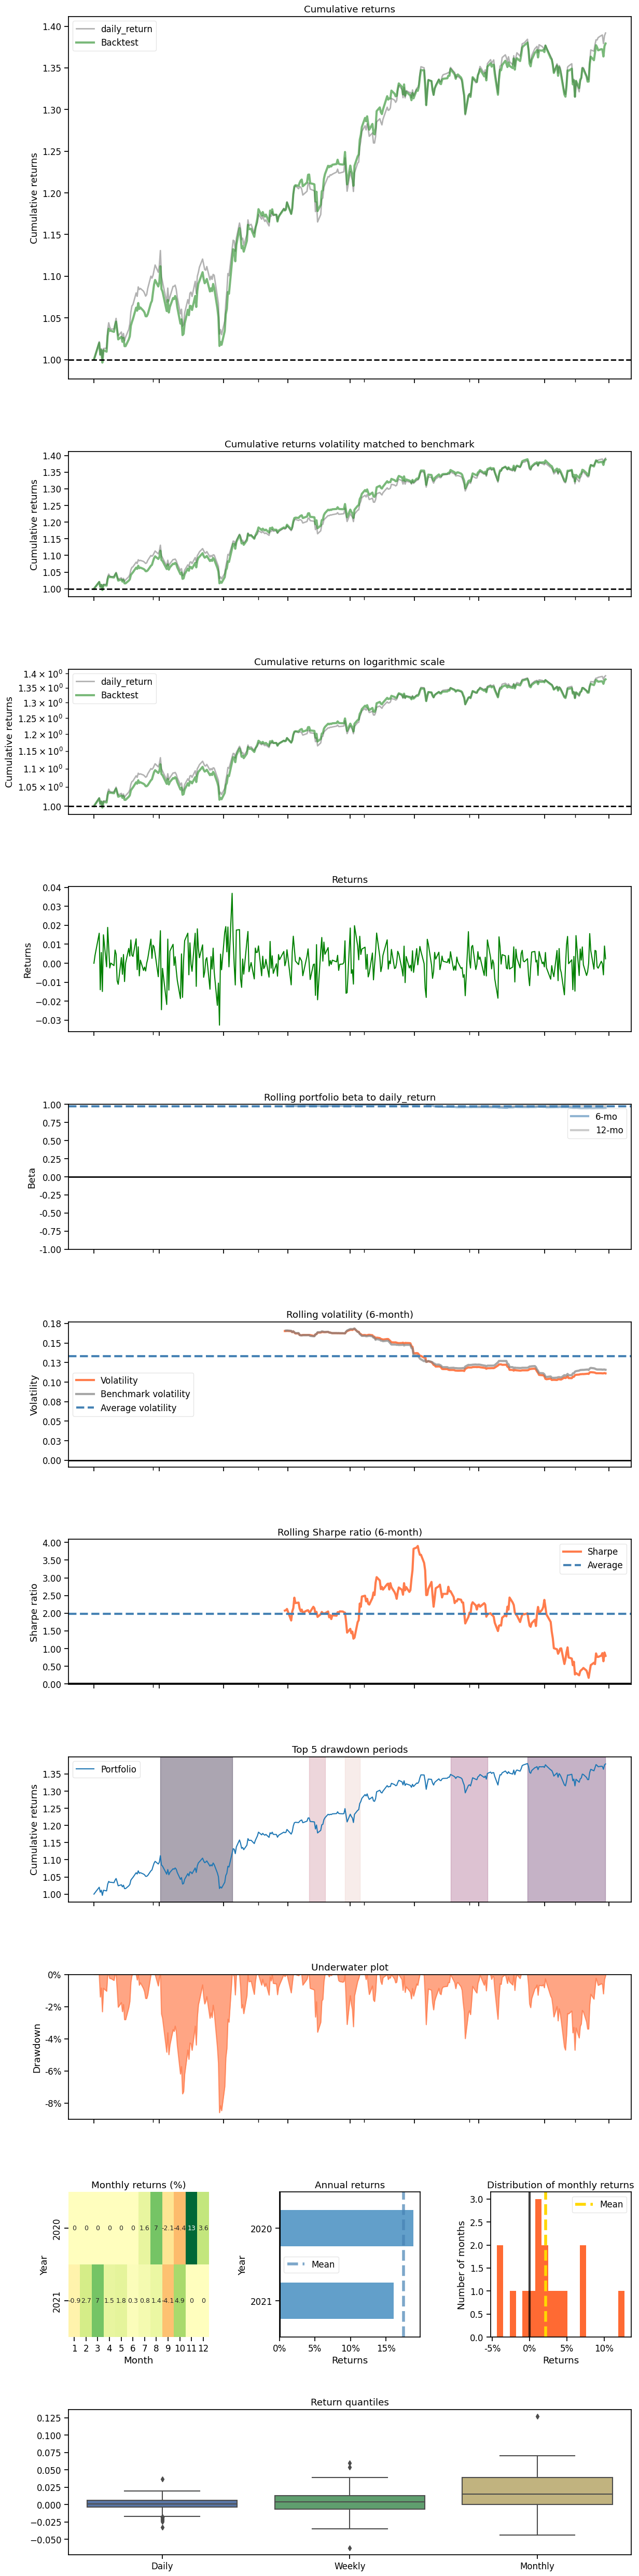

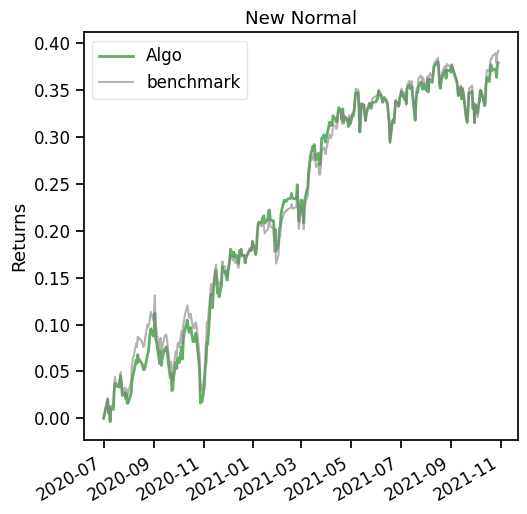

In [128]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

# Min-Variance Portfolio Allocation

In [129]:
%pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [130]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()
df.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,607541200,AAPL,-0.097446,3.649552,2.895305,42.254771,-80.847207,16.129793,3.243631,3.375887,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,57.750000,6287200,AMGN,0.216368,58.947401,56.388599,51.060614,51.895357,10.432018,56.671334,56.044333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,18.549999,9625600,AXP,-1.191668,23.723023,16.106977,42.521170,-74.811722,25.776759,20.030000,22.412000,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,42.669998,5443100,BA,-0.391219,42.894634,38.486366,47.290375,157.922391,5.366299,40.432000,43.304500,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,44.669998,6277400,CAT,0.979845,45.785565,38.404435,51.073052,98.904653,26.331746,40.266000,39.918333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...


In [131]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [133]:
portfolio.tail()

,account_value
2021-10-25,1205808.458303
2021-10-26,1209829.552498
2021-10-27,1207199.475773
2021-10-28,1220930.462284
2021-10-29,1226894.679448


In [134]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1
dji_cumpod =(baseline_returns+1).cumprod()-1

# Plotly: DRL, Min-Variance, DJIA

In [135]:
%pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 40.6 MB/s eta 0:00:00


In [136]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [137]:
time_ind = pd.Series(df_daily_return.date)

In [138]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [139]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()